In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import DBSCAN

In [2]:
_bb=pd.read_csv('bkk_budget_ocr.csv',index_col=0)
_bb=_bb[~_bb['pagenum'].isna()]

/Users/napatswift/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# number of document
len(_bb.pdf.unique())

385

In [4]:
_bb['pagenum'] = _bb['pagenum'].astype(int)
_bb['text'] = _bb['text'].astype(str)

select test set

In [5]:
interested_doc = [
    'pdf/61/A20171003163303.pdf', 
    'pdf/61/A20171003164329.pdf', 
    'pdf/61/A20171003170601.pdf', 
    'pdf/62/A20181002170334.pdf',
    'pdf/64/topic2787_2020_10_06_10_18_31.pdf',
    'pdf/64/topic2787_2020_10_06_10_18_51.pdf']

create total sum of the document for validation

In [6]:
answers = {
    'pdf/61/A20171003163303.pdf': {'sum':691_229_200, 'start': 3},
    'pdf/61/A20171003164329.pdf': {'sum': 386_943_640, 'start': 5},
    'pdf/61/A20171003170601.pdf': {'sum': 365_299_840, 'start': 5},
    'pdf/62/A20181002170334.pdf': {'sum': 357_892_000, 'start': 5},
    'pdf/64/topic2787_2020_10_06_10_18_31.pdf': {'sum': 424_674_000, 'start': 5},
    'pdf/64/topic2787_2020_10_06_10_18_51.pdf': {'sum': 398_016_000, 'start': 5},
    }

remove unwanted document (just for develop)

In [7]:
bb=_bb[_bb.pdf.isin(interested_doc)]

fix text by dict

In [8]:
chr_fix_pair={'ำ': 'า','/า': 'ำ', '/้า': '้ำ'}

In [9]:
def fix_pdf_text(old_text):
    new_text = old_text.strip()
    for o,n in chr_fix_pair.items():
        new_text=new_text.replace(o,n)
    return new_text

bb=bb.assign(fix_text=bb.text.apply(fix_pdf_text))

replace text from pdf with OCR text

In [10]:
bb.loc[~bb['ocr-text'].isna(), 'fix_text'] = bb[~bb['ocr-text'].isna()]['ocr-text']

group line

In [11]:
max_dist = 0.7
dbscan = DBSCAN(eps=max_dist, min_samples=0, metric='precomputed')
for g, idx in tqdm(bb.groupby('image_path').groups.items()):
    out = bb.loc[idx][['x0', 'x1', 'y0', 'y1']]
    out['h'] = out.y1 - out.y0
    num_bboxes = len(idx)
    idx2idx = {j:i for i,j in enumerate(idx)}
    n_dist_mat = np.ones((num_bboxes, num_bboxes))
    dist_mat = np.ones((num_bboxes, num_bboxes))
    
    for i in range(num_bboxes):
        a = out.iloc[i]
        _out=out.loc[idx[i:]]
        _skip = (a.y0 > _out.y1) | (_out.y0 > a.y1)
        _out = _out[~_skip]
        intersection = np.minimum(a.y1, _out.y1) - np.maximum(a.y0, _out.y0)
        union = a.h + _out.h - intersection
        iou = np.clip(intersection / (union + 1e-10), 0, 1)
        idicies = [idx2idx[i] for i in iou.index]
        n_dist_mat[i, idicies] = n_dist_mat[idicies, i] = 1-iou.values

    fdbscan = dbscan.fit(n_dist_mat)
    bb.loc[idx, 'line_label'] = fdbscan.labels_

100%|█████████████████████████████████████████| 221/221 [01:00<00:00,  3.63it/s]


In [12]:
bb.loc[:, 'line_label'] = bb.line_label.astype(int)

In [46]:
bb=bb.assign(fisical_year=bb.pdf.apply(lambda v: int(re.findall('/6\d/', v)[0][1:-1])))

In [91]:
# bb.sort_values(['fisical_year', 'pagenum', 'line_label', 'y0', 'x0'])

# Try to parse

In [111]:
import re
def get_patern_of_bullet(String):
    regx = [
        ('^0[-\d]+$', 70),
        ('^\(\d*(\.?\d*)*\)$', 50),
        ('^[1-9]\d*(\.[1-9]\d*)*\)$', 20),
        ('^[1-9]\d*(\.[1-9]\d*)+$', 5),
        ('^[1-9]\d*\.$', 4),
        ('^งาน', 3),
        ('^แผนงาน', 2),
        ('^[\u0E00-\u0E7F]\.$', 1)
    ]
    
    if String in ['ด้านการจัดบริการของสำนักงานเขต',
                  'ด้านการบริหารจัดการและบริหารราชการกรุงเทพมหานคร',
                  'ด้านการศึกษา',
                  'ด้านความปลอดภัยและความเป็นระเบียบเรียบร้อย',
                  'ด้านทรัพยากรธรรมชาติและสิ่งแวดล้อม',
                  'ด้านพัฒนาสังคมและชุมชนเมือง',
                  'ด้านสาธารณสุข',
                  'ด้านเมืองและการพัฒนาเมือง',
                  'ด้านเศรษฐกิจและการพาณิชย์']: return ('ด้าน',1)

    for r, l in regx:
        if re.match(r, String):
            if l in [5, 20, 50]:
                l = String.count('.') + l
            if r == '^งาน' and String == 'งานที่จะทำ': continue
            return r, l
    return '', 0

In [112]:
bb_with_entry = bb.copy()

In [142]:
entry_label_id = 0

is_entry = False
for (pdf_name, pdf_page_index), page_df in tqdm(bb[~bb.line_label.isna()].groupby(['pdf','pagenum'])):
    if pdf_page_index + 1 < answers[pdf_name]['start']: continue
    for line_num, line_df in page_df.groupby('line_label'):
        if (line_df.fix_text == 'รายละเอียดรายจ่าย').any(): continue

        if (line_df.fix_text.isin(['ปี', '2560', 'บาท'])).sum() == 3:
            continue

        if line_num == 0: continue

        text_line = line_df.sort_values(by='x0',ascending=True).fix_text.values
        bullet_code = get_patern_of_bullet(text_line[0])[1]
        
        if bullet_code == 70:
            if len(text_line) > 1:
                second_bullet = get_patern_of_bullet(text_line[1])[1]
                if second_bullet != 0: bullet_code = second_bullet
            if len(text_line) > 2:
                third_bullet = get_patern_of_bullet(text_line[2])[1]
                if third_bullet != 0: bullet_code = third_bullet
        
        if bullet_code != 0:
            entry_label_id += 1
            bb_with_entry.loc[line_df.index, 'bullet_label'] = bullet_code
            is_entry = True

        if is_entry:
            bb_with_entry.loc[line_df.index, 'entry_label'] = entry_label_id

        is_last_token_baht = text_line[-1] == 'บาท'
        if is_last_token_baht:
            is_entry = False

100%|█████████████████████████████████████████| 221/221 [00:06<00:00, 36.32it/s]


In [143]:
# inspect them
start_entry=bb_with_entry[~bb_with_entry.bullet_label.isna()].groupby(['pdf','pagenum','entry_label']).x0.min()
start_entry.mean(),start_entry.std(),start_entry.mean()+start_entry.std(),start_entry.max()

(245.0176680897156, 106.01422048337417, 351.03188857308976, 633.0299835205078)

In [144]:
# bb_with_entry[~bb_with_entry.bullet_label.isna() & (bb_with_entry.x0 < 400 )].fix_text.values.tolist()

In [145]:
# test print by entry
bb_with_entry.iloc[:600]\
    .groupby(['pdf','pagenum', 'entry_label'])\
    .apply(lambda x: (x.iloc[0].entry_label,
                      np.unique(x.bullet_label.values.tolist()),
                      ' '.join(x.fix_text.values.tolist())
                     )
          )\
    .to_list();

Relation extraction

pairing parent node with child nodes

In [146]:
bb_with_entry[bb_with_entry.entry_label == 1].pdf.iloc[0]

'pdf/61/A20171003163303.pdf'

In [147]:
entry_bullet_table = bb_with_entry.groupby('entry_label').apply(lambda x: x.bullet_label.unique()[0])
entry_page_num_table = bb_with_entry.groupby('entry_label').apply(lambda x: x.pagenum.unique()[0])
entry_text_table = bb_with_entry.groupby('entry_label').apply(lambda x: ' '.join(x.fix_text.values))

In [148]:
child_parent_table = dict()
curr = None
for entry, bullet in entry_bullet_table.items():
    while (curr != None and bullet <= entry_bullet_table[curr]):
        curr = child_parent_table[curr]
    child_parent_table[entry] = curr
    curr = entry

# for c, p in child_parent_table.items():
#     print(c,p)
#     print(p, None if p is None else entry_text_table.loc[p], c,entry_text_table.loc[c])
#     if c > 30: break

In [149]:
from graphviz import Digraph

In [150]:
spdf_name = bb_with_entry.pdf.unique()[-1]

In [168]:
def get_child_of(tp):
    return [c for c, p in child_parent_table.items() if p == tp]

In [174]:
def desc(tp):
    out = [tp]
    for x in get_child_of(tp):
        out += desc(x)
    return out

In [187]:
entry_bullet_table[entry_bullet_table == 1].index[1]

226.0

In [191]:
d=Digraph('diagram',graph_attr={'rankdir': 'RL'})
d.attr('node')
desc_list = desc(entry_bullet_table[entry_bullet_table == 1].index[2])
d.attr('node',shape='box')
for c,p in child_parent_table.items():
    if c not in desc_list: continue
    pdf_name = bb_with_entry[bb_with_entry.entry_label == c].pdf.iloc[0]
#     if pdf_name != spdf_name: continue
    cs = str(c)
    ps = str(p)
    
    node_label = entry_text_table.loc[c]
    
    amount = re.findall('[\d,]+ บาท', node_label)
    node_label = re.sub('[\d,]+ บาท', '', node_label)
    node_label = node_label[:100] + (amount[0] if len(amount) > 0 else '')
    
    d.node(cs, node_label)
    if p is None:
        ps = pdf_name

    d.edge(cs, ps)
    pagenum = entry_page_num_table[c]

In [197]:
# d.render(pdf_name.replace('/','-').replace('.', '-'),format='svg')
d.render('out',format='png')

'out.png'

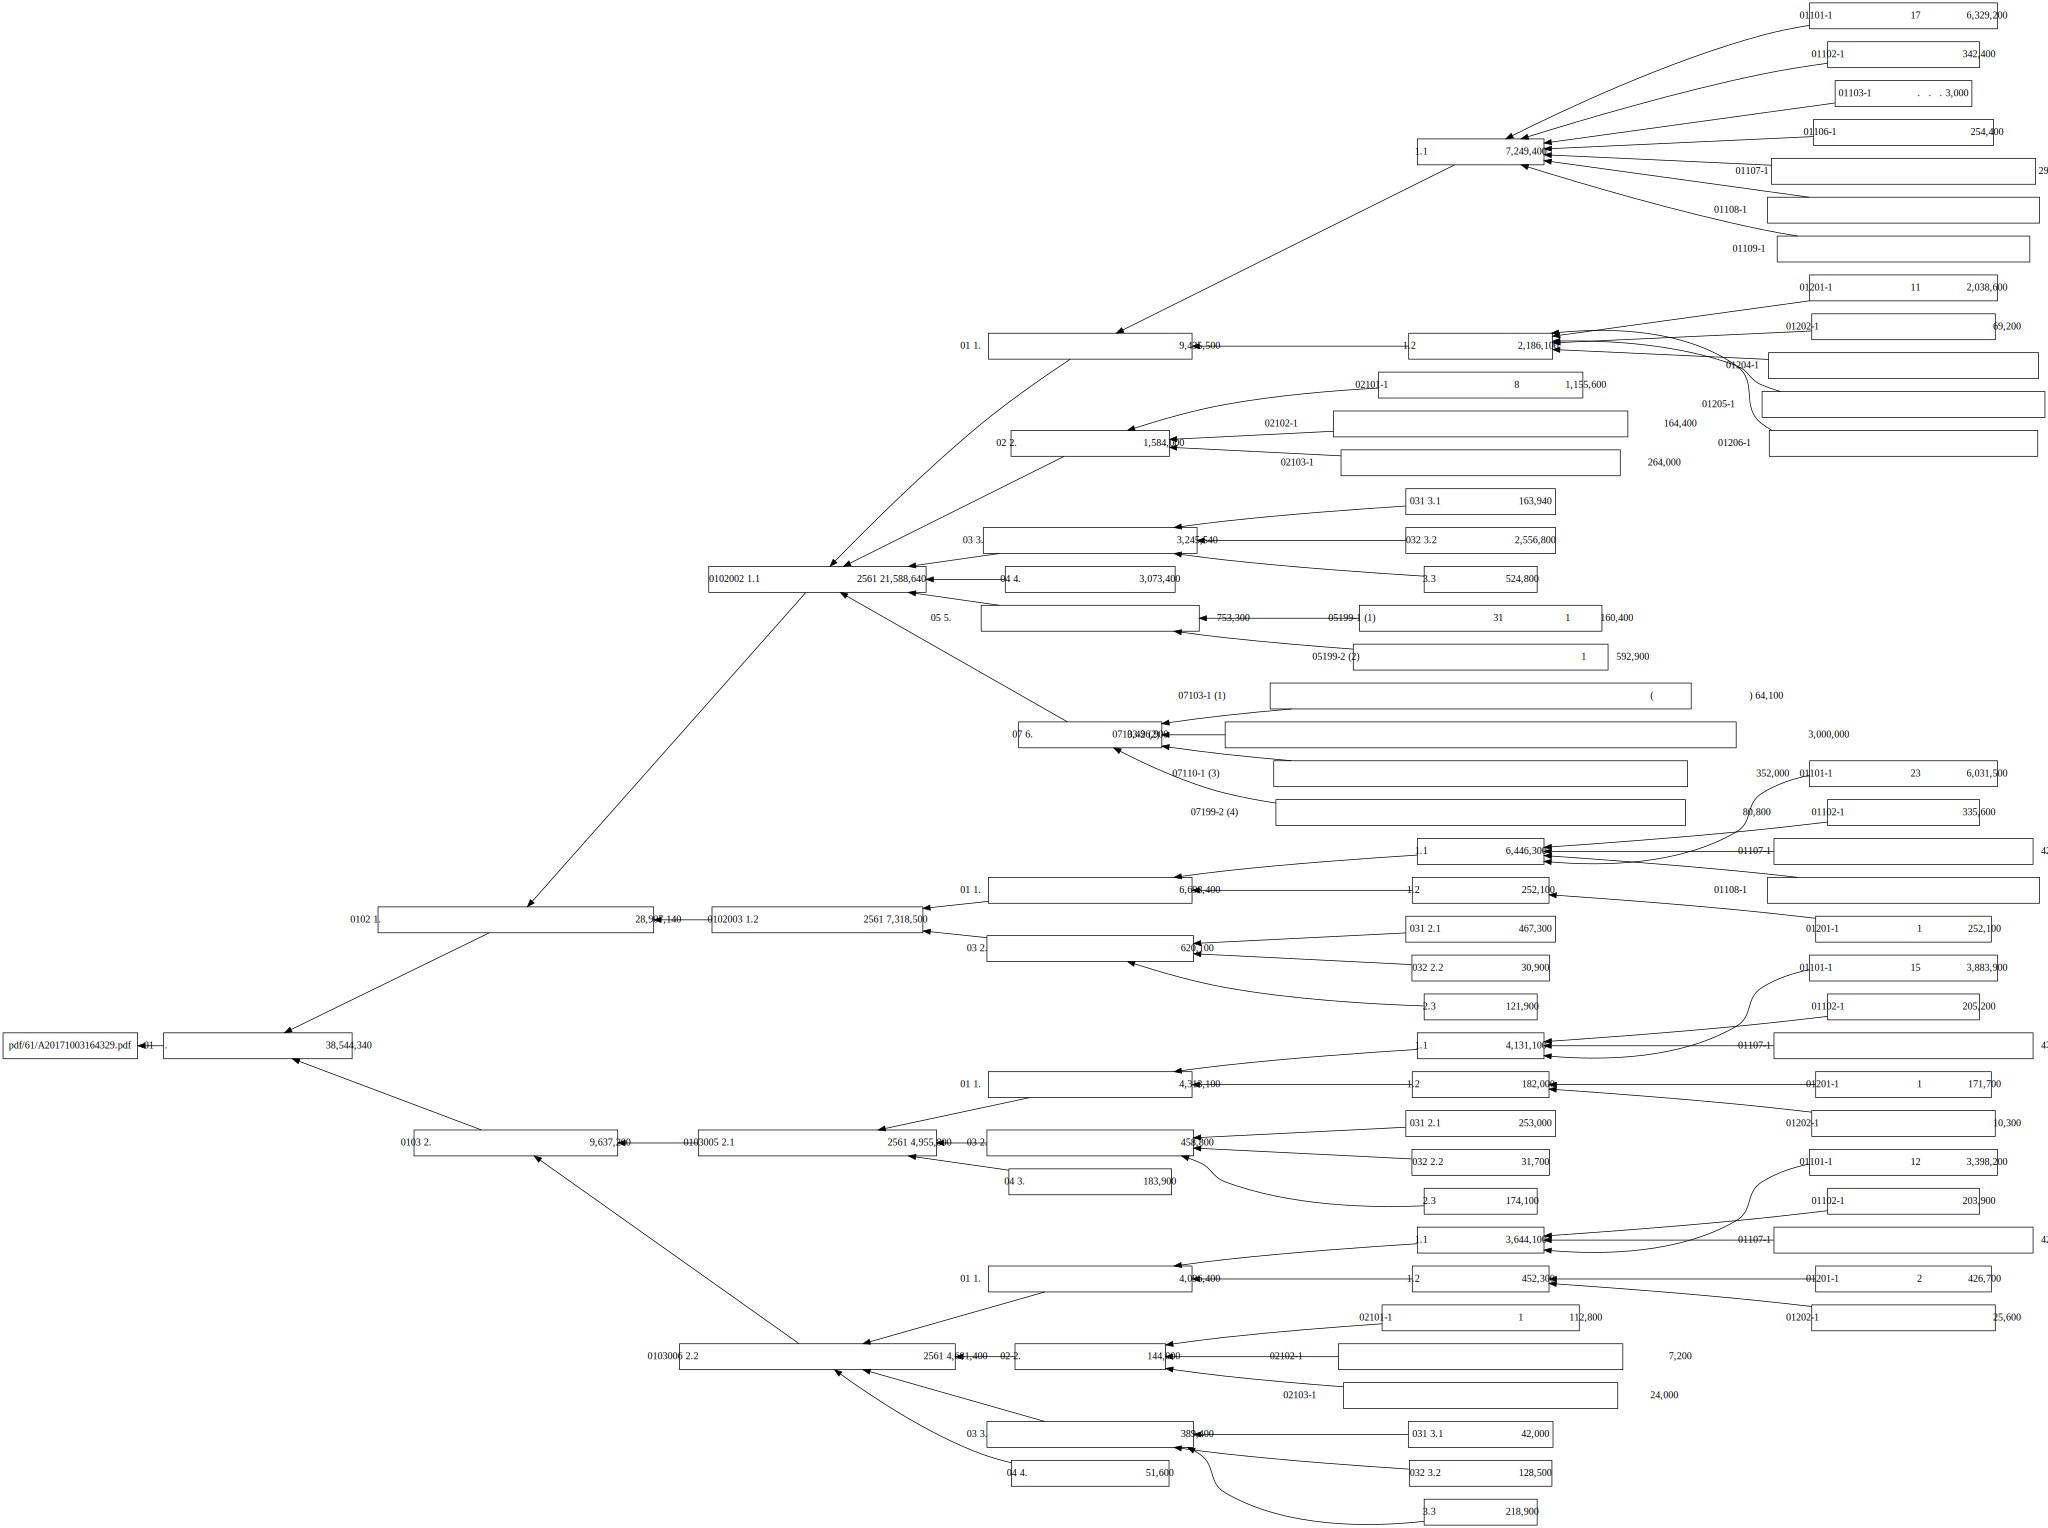

In [195]:
d